# Ch7 | Pre-training 实战：炼制你的 TinyLlama

---

**目标：** 从零训练一个能生成文本的语言模型

**核心问题：** 如何让模型学会"说人话"？

**设备建议：** CPU 可跑（演示为主），GPU 可加速。

**路线说明：** 本章为预训练演示；后续 Ch8–Ch10 进入 GPT-2 基座的工程微调。

---

## 本章内容

1. **数据工程**：Dataset 和 DataLoader
2. **训练循环**：完整的预训练流程
3. **Checkpoint**：模型保存与加载
4. **实战**：在生成的数据集上训练

---

## 🎓 前置知识：什么是预训练？

### 语言模型的核心任务

LLM 的预训练目标非常简单：

$$预测下一个词$$

```
输入: "今天天气真"
目标: "好"

输入: "机器学习是人工智能的一个"
目标: "分支"
```

就这么简单！但通过在**海量文本**上做这个任务，模型能学到：
- 语法规则
- 常识知识
- 推理能力

### 预训练的数据规模

| 模型 | 训练数据量 | 参数量 |
|:---|:---|:---|
| GPT-2 | 40 GB | 1.5B |
| GPT-3 | 570 GB | 175B |
| LLaMA | 1.4 TB | 7B-65B |


### 训练流程

```
原始文本 → Tokenizer → 数字序列 → Dataset → DataLoader → 模型 → Loss → 更新参数
```

关键组件：
1. **Dataset**：封装数据，提供 (输入, 目标) 对
2. **DataLoader**：批量加载，打乱顺序
3. **训练循环**：前向 → 计算Loss → 反向 → 更新

### 学习率调度

训练技巧：学习率不是固定的！

```
开始: 学习率从0慢慢增加 (Warmup)
中间: 保持较高学习率
结束: 学习率逐渐降低 (Decay)
```

### 本章目标

- 准备训练数据（本地中文语料）
- 实现完整的训练循环
- 学会保存和加载 Checkpoint
- 用训练好的模型生成文本！

## 0. 环境准备

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import time
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Noto Sans CJK SC", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


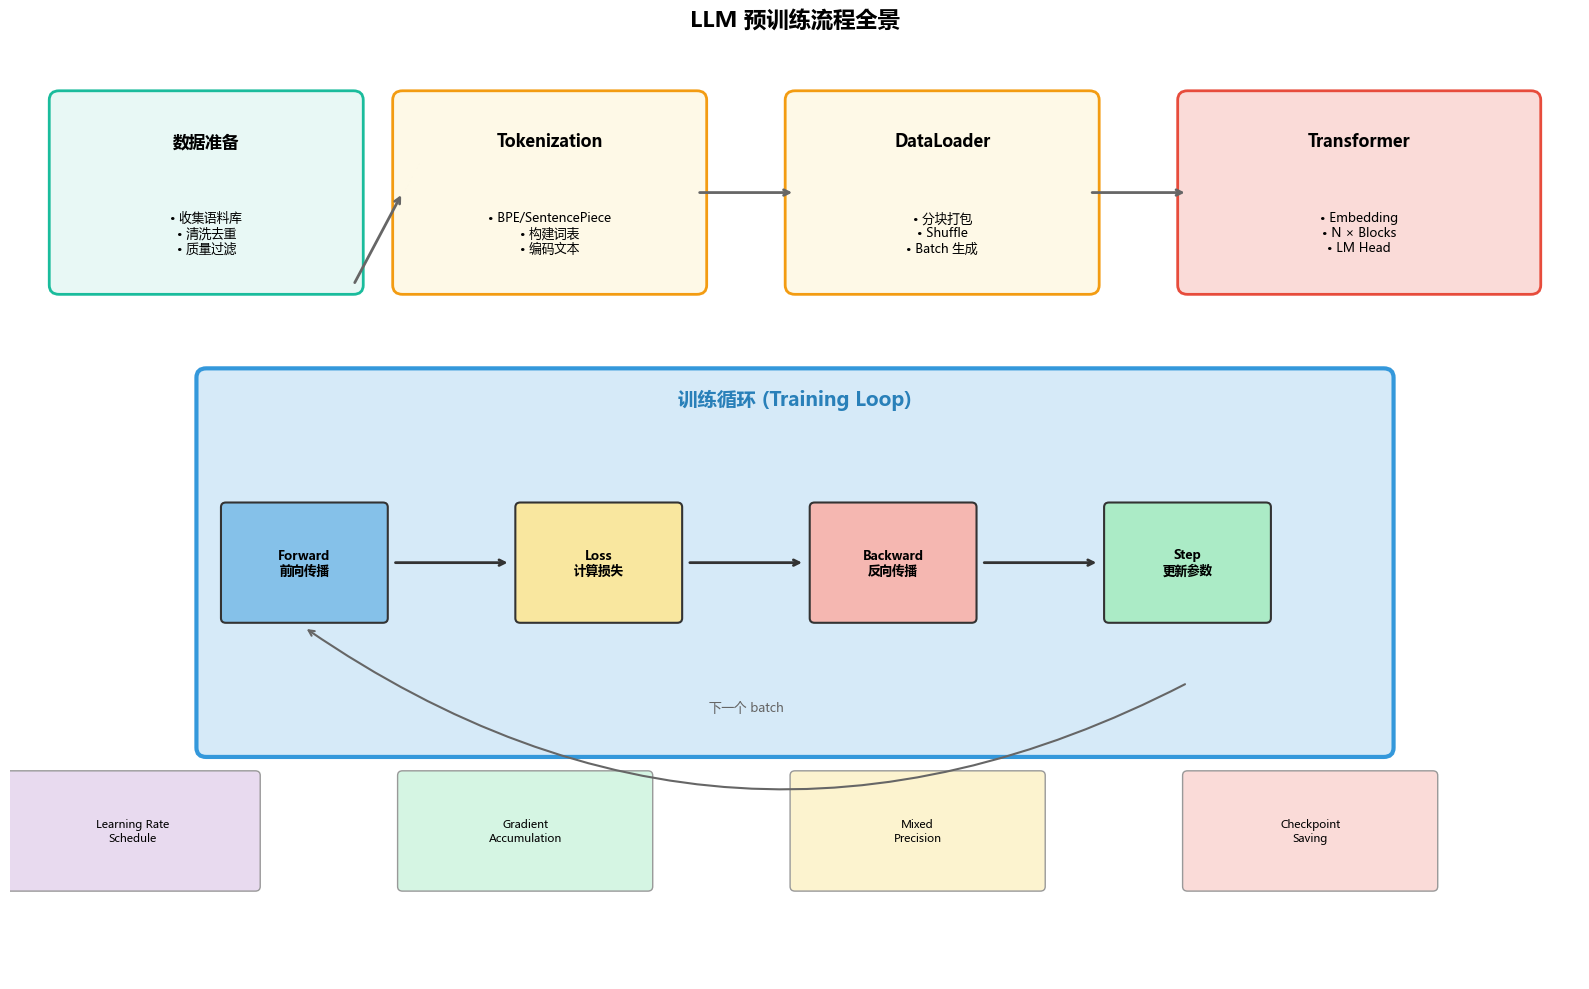


 预训练核心要点:
   1. 数据质量 > 数据数量 (垃圾进垃圾出)
   2. 学习率调度至关重要 (warmup + cosine decay)
   3. 梯度累积可以模拟更大 batch size
   4. 定期保存 checkpoint 防止意外


In [24]:
# 🎨 LLM 预训练全景图
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import numpy as np

def visualize_pretraining_pipeline():
    """
    可视化 LLM 预训练的完整流程
    """
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_title('LLM 预训练流程全景', fontsize=16, fontweight='bold', pad=20)
    
    # 颜色定义
    colors = {
        'data': '#E8F8F5',
        'process': '#FEF9E7', 
        'model': '#FADBD8',
        'train': '#D6EAF8',
        'output': '#D5F5E3'
    }
    
    # ===== 阶段1: 数据准备 =====
    ax.add_patch(FancyBboxPatch((0.5, 7.5), 3, 2, boxstyle='round,pad=0.1',
                                facecolor=colors['data'], edgecolor='#1ABC9C', linewidth=2))
    ax.text(2, 9, '数据准备', fontsize=12, ha='center', fontweight='bold')
    ax.text(2, 8.3, '• 收集语料库\n• 清洗去重\n• 质量过滤', fontsize=9, ha='center', va='top')
    
    # ===== 阶段2: Tokenization =====
    ax.add_patch(FancyBboxPatch((4, 7.5), 3, 2, boxstyle='round,pad=0.1',
                                facecolor=colors['process'], edgecolor='#F39C12', linewidth=2))
    ax.text(5.5, 9, 'Tokenization', fontsize=12, ha='center', fontweight='bold')
    ax.text(5.5, 8.3, '• BPE/SentencePiece\n• 构建词表\n• 编码文本', fontsize=9, ha='center', va='top')
    
    # ===== 阶段3: 数据加载 =====
    ax.add_patch(FancyBboxPatch((8, 7.5), 3, 2, boxstyle='round,pad=0.1',
                                facecolor=colors['process'], edgecolor='#F39C12', linewidth=2))
    ax.text(9.5, 9, 'DataLoader', fontsize=12, ha='center', fontweight='bold')
    ax.text(9.5, 8.3, '• 分块打包\n• Shuffle\n• Batch 生成', fontsize=9, ha='center', va='top')
    
    # ===== 阶段4: 模型 =====
    ax.add_patch(FancyBboxPatch((12, 7.5), 3.5, 2, boxstyle='round,pad=0.1',
                                facecolor=colors['model'], edgecolor='#E74C3C', linewidth=2))
    ax.text(13.75, 9, 'Transformer', fontsize=12, ha='center', fontweight='bold')
    ax.text(13.75, 8.3, '• Embedding\n• N × Blocks\n• LM Head', fontsize=9, ha='center', va='top')
    
    # ===== 阶段5: 训练循环 (中间大框) =====
    ax.add_patch(FancyBboxPatch((2, 2.5), 12, 4, boxstyle='round,pad=0.1',
                                facecolor=colors['train'], edgecolor='#3498DB', linewidth=3))
    ax.text(8, 6.2, '训练循环 (Training Loop)', fontsize=14, ha='center', fontweight='bold', color='#2980B9')
    
    # 训练步骤
    steps = [
        (3, 4.5, 'Forward\n前向传播', '#85C1E9'),
        (6, 4.5, 'Loss\n计算损失', '#F9E79F'),
        (9, 4.5, 'Backward\n反向传播', '#F5B7B1'),
        (12, 4.5, 'Step\n更新参数', '#ABEBC6'),
    ]
    
    for x, y, text, color in steps:
        ax.add_patch(FancyBboxPatch((x-0.8, y-0.6), 1.6, 1.2, boxstyle='round,pad=0.05',
                                    facecolor=color, edgecolor='#333', linewidth=1.5))
        ax.text(x, y, text, fontsize=9, ha='center', va='center', fontweight='bold')
    
    # 循环箭头
    for i in range(3):
        ax.annotate('', xy=(steps[i+1][0]-0.9, 4.5), xytext=(steps[i][0]+0.9, 4.5),
                   arrowprops=dict(arrowstyle='->', color='#333', lw=2))
    
    # 回到开始的循环
    ax.annotate('', xy=(3, 3.8), xytext=(12, 3.2),
               arrowprops=dict(arrowstyle='->', color='#666', lw=1.5, 
                              connectionstyle='arc3,rad=-0.3'))
    ax.text(7.5, 2.9, '下一个 batch', fontsize=9, ha='center', color='#666')
    
    # ===== 训练技巧标注 =====
    techniques = [
        (1, 1.5, 'Learning Rate\nSchedule', '#E8DAEF'),
        (5, 1.5, 'Gradient\nAccumulation', '#D5F5E3'),
        (9, 1.5, 'Mixed\nPrecision', '#FCF3CF'),
        (13, 1.5, 'Checkpoint\nSaving', '#FADBD8'),
    ]
    
    for x, y, text, color in techniques:
        ax.add_patch(FancyBboxPatch((x-1, y-0.5), 2.5, 1.2, boxstyle='round,pad=0.05',
                                    facecolor=color, edgecolor='#999', linewidth=1))
        ax.text(x+0.25, y+0.1, text, fontsize=8, ha='center', va='center')
    
    # 连接箭头
    arrows = [(3.5, 7.5, 4, 8.5), (7, 8.5, 8, 8.5), (11, 8.5, 12, 8.5)]
    for x1, y1, x2, y2 in arrows:
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color='#666', lw=2))
    
    plt.tight_layout()
    plt.show()
    
    print("\n 预训练核心要点:")
    print("   1. 数据质量 > 数据数量 (垃圾进垃圾出)")
    print("   2. 学习率调度至关重要 (warmup + cosine decay)")
    print("   3. 梯度累积可以模拟更大 batch size")
    print("   4. 定期保存 checkpoint 防止意外")

visualize_pretraining_pipeline()

---

## 1. 准备数据：中文预训练语料

In [25]:
# 读取本地中文预训练语料
from pathlib import Path

def resolve_data_dir():
    candidates = [Path.cwd(), Path.cwd().parent]
    for base in candidates:
        data_dir = base / "data"
        if data_dir.exists():
            return str(data_dir)
    return os.path.join(os.getcwd(), "data")

DATA_DIR = resolve_data_dir()
PROJECT_ROOT = str(Path(DATA_DIR).parent)
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODELS_DIR, exist_ok=True)
data_path = os.path.join(DATA_DIR, "custom_pretrain_corpus.txt")
BEST_MODEL_PATH = os.path.join(MODELS_DIR, "ch7_pretrain_best_model.pt")
CHECKPOINT_PATH = os.path.join(MODELS_DIR, "ch7_pretrain_checkpoint.pt")

if not os.path.exists(data_path):
    raise FileNotFoundError(f"未找到预训练语料: {data_path}")

with open(data_path, "r", encoding="utf-8") as f:
    text = f.read()

print(f"数据集大小: {len(text):,} 字符")
print("\n前500字符预览:")
print(text[:500])

数据集大小: 3,782 字符

前500字符预览:
企业年度预算通常按部门拆分，并在季度复盘时滚动更新。
项目计划需要明确里程碑、交付物和风险缓释措施。
需求评审应记录变更原因与影响范围，便于后续追踪。
软件发布应区分功能开关与版本回滚策略，降低上线风险。
持续集成流水线应包含静态检查、单元测试与制品签名。
日志字段需要统一命名规范，便于跨系统检索。
服务等级协议通常包含可用性、响应时间与赔偿条款。
网络隔离可以通过子网划分与访问控制列表实现。
数据仓库建模常用星型或雪花结构以支持分析。
指标口径必须稳定，否则历史趋势难以比较。
数据采集应遵循最小必要原则，避免无关字段堆积。
版本管理应采用语义化版本号并维护清晰的变更记录。
代码审查关注边界条件、可读性和潜在的安全问题。
系统容量规划需要结合峰值流量与增长预期。
缓存设计要考虑一致性、失效策略与热点穿透。
业务告警应避免噪声过大，并提供可执行的处理建议。
备份策略要覆盖全量与增量，并定期进行恢复演练。
灾备设计需要明确切换流程与恢复时间目标。
API 文档应包含请求示例、字段说明和错误码。
设备巡检记录需可追溯，并保留责任人签名。
供应链管理强调准时交付、库存周转和供应风险控制。
采购


In [26]:
# 构建字符级词表
chars = sorted(list(set(text)))
vocab_size = len(chars)

# 字符到索引的映射
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# 编码解码函数
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(f"词表大小: {vocab_size}")
print(f"词表: {''.join(chars)}")

# 测试（使用语料中的字符，避免 OOV）
test_str = text[:10]
encoded = encode(test_str)
decoded = decode(encoded)
print(f"\n测试编码解码:")
print(f"  原文: {test_str}")
print(f"  编码: {encoded}")
print(f"  解码: {decoded}")

词表大小: 624
词表: 
 "%+,-./0123458:@ABCDEFGHIJLMNOPRSTUWY_abcdefgiklmnopqrstuvwxy{}、。一上下与业严中为主义习事二于交产享人从仓付代令以仪件任份企优会传估伸位低体作使例供依便保信修债值偏做健偿储像元先免入全公共关具兼册再写决冷准减出分切划列则删别到制前力办功加务动助势包化区升协单占历压原去参反发取变口只可台史号合同名后向否含启告员周命和品响商器噪四回因团围固图在地场型域培基堆境增声处备复多大天失如子字存季学安完定实审客容密对寻导小少层岗峰巡工差布常幂平年并序库应度康延建开异式引强归录形影征径待得循心必志态急性恢息意感成或户所手执扩扫批技折护报拆拉持指按损换据授排接控推措描提摘操支收改放政故效敏数整文料新方施无日旧时明易星是景晰暴更最有服期本术机杂权束条来板构析查标样核根格案档桶梯检模次款止步死段比水求池泄法波注洁洗洞活流测消清源溯滚满滤漏演潜灰灾点热版牌物特状独率环现班理瓶生用由申电画界留略的监盖盘目看知短码研硬确碑示禁离私种积移程稳穿窗立章端符等策签简算管箱篡粒系索紧约级纪线练经结络统绩续维缓编缩网置考而联背能脏脚脱自致舍色节花范荐营虑行衡补表要覆见观规角解触言警计订认训议记论设访证评识试语误说请读调负财责账质购资赔赖起超趋跟跨路踪身转轮软较辅输边迁过运进连迟追选透逐途通速遵避邮部配采释里重量金鉴钻链销锁错键长门闭问间队防阶降限除险隆随隐隔障难集雪需静面项须预领颈题额风馈验高默，：

测试编码解码:
  原文: 企业年度预算通常按部
  编码: [95, 71, 251, 256, 612, 456, 567, 248, 301, 572]
  解码: 企业年度预算通常按部


---

## 2. 创建 Dataset 和 DataLoader

In [27]:
class TextDataset(Dataset):
    """
    文本数据集：每个样本是 (input, target) 对
    target 是 input 右移一位
    """
    def __init__(self, text, block_size):
        self.data = torch.tensor(encode(text), dtype=torch.long)
        self.block_size = block_size
    
    def __len__(self):
        return len(self.data) - self.block_size
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.block_size]
        y = self.data[idx + 1:idx + self.block_size + 1]
        return x, y

# 训练/验证集划分
n = int(0.9 * len(text))
train_text = text[:n]
val_text = text[n:]

block_size = 64  # 上下文长度
batch_size = 32

train_dataset = TextDataset(train_text, block_size)
val_dataset = TextDataset(val_text, block_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"训练集大小: {len(train_dataset):,}")
print(f"验证集大小: {len(val_dataset):,}")
print(f"每个 batch: {batch_size} 个序列，每个序列 {block_size} tokens")

# 查看一个 batch
x, y = next(iter(train_loader))
print(f"\nBatch 形状: x={x.shape}, y={y.shape}")
print(f"\n样本展示:")
print(f"  输入:  {decode(x[0].tolist())}")
print(f"  目标:  {decode(y[0].tolist())}")

训练集大小: 3,339
验证集大小: 315
每个 batch: 32 个序列，每个序列 64 tokens

Batch 形状: x=torch.Size([32, 64]), y=torch.Size([32, 64])

样本展示:
  输入:  等关键指标。
实验对比必须固定随机种子。
线上模型需要灰度发布与回滚策略。
配置中心应支持动态下发与版本管理。
脚本任务应设置重
  目标:  关键指标。
实验对比必须固定随机种子。
线上模型需要灰度发布与回滚策略。
配置中心应支持动态下发与版本管理。
脚本任务应设置重试


---

## 3. 定义模型（使用上一章的 GPT）

In [28]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config['n_head']
        self.n_embd = config['n_embd']
        self.head_dim = config['n_embd'] // config['n_head']
        
        self.c_attn = nn.Linear(config['n_embd'], 3 * config['n_embd'])
        self.c_proj = nn.Linear(config['n_embd'], config['n_embd'])
        self.dropout = nn.Dropout(config['dropout'])
        
        self.register_buffer("mask", torch.tril(
            torch.ones(config['block_size'], config['block_size'])
        ).view(1, 1, config['block_size'], config['block_size']))
    
    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        
        att = (q @ k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        
        y = (att @ v).transpose(1, 2).contiguous().view(B, T, C)
        return self.c_proj(y)

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config['n_embd'], 4 * config['n_embd'])
        self.c_proj = nn.Linear(4 * config['n_embd'], config['n_embd'])
        self.dropout = nn.Dropout(config['dropout'])
    
    def forward(self, x):
        return self.dropout(self.c_proj(F.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config['n_embd'])
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config['n_embd'])
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config['vocab_size'], config['n_embd']),
            wpe = nn.Embedding(config['block_size'], config['n_embd']),
            drop = nn.Dropout(config['dropout']),
            h = nn.ModuleList([Block(config) for _ in range(config['n_layer'])]),
            ln_f = nn.LayerNorm(config['n_embd']),
        ))
        self.lm_head = nn.Linear(config['n_embd'], config['vocab_size'], bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        B, T = idx.size()
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        
        x = self.transformer.drop(self.transformer.wte(idx) + self.transformer.wpe(pos))
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config['block_size'] else idx[:, -self.config['block_size']:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# 模型配置
config = {
    'vocab_size': vocab_size,
    'block_size': block_size,
    'n_layer': 4,
    'n_head': 4,
    'n_embd': 128,
    'dropout': 0.1,
}

model = GPT(config).to(device)
print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")

模型参数量: 881,408


---

## 4. 训练循环

> 说明：本章主要演示流程，训练配置与数据规模仅用于示例。更完整的训练实践见 Custom_GPT_Training。


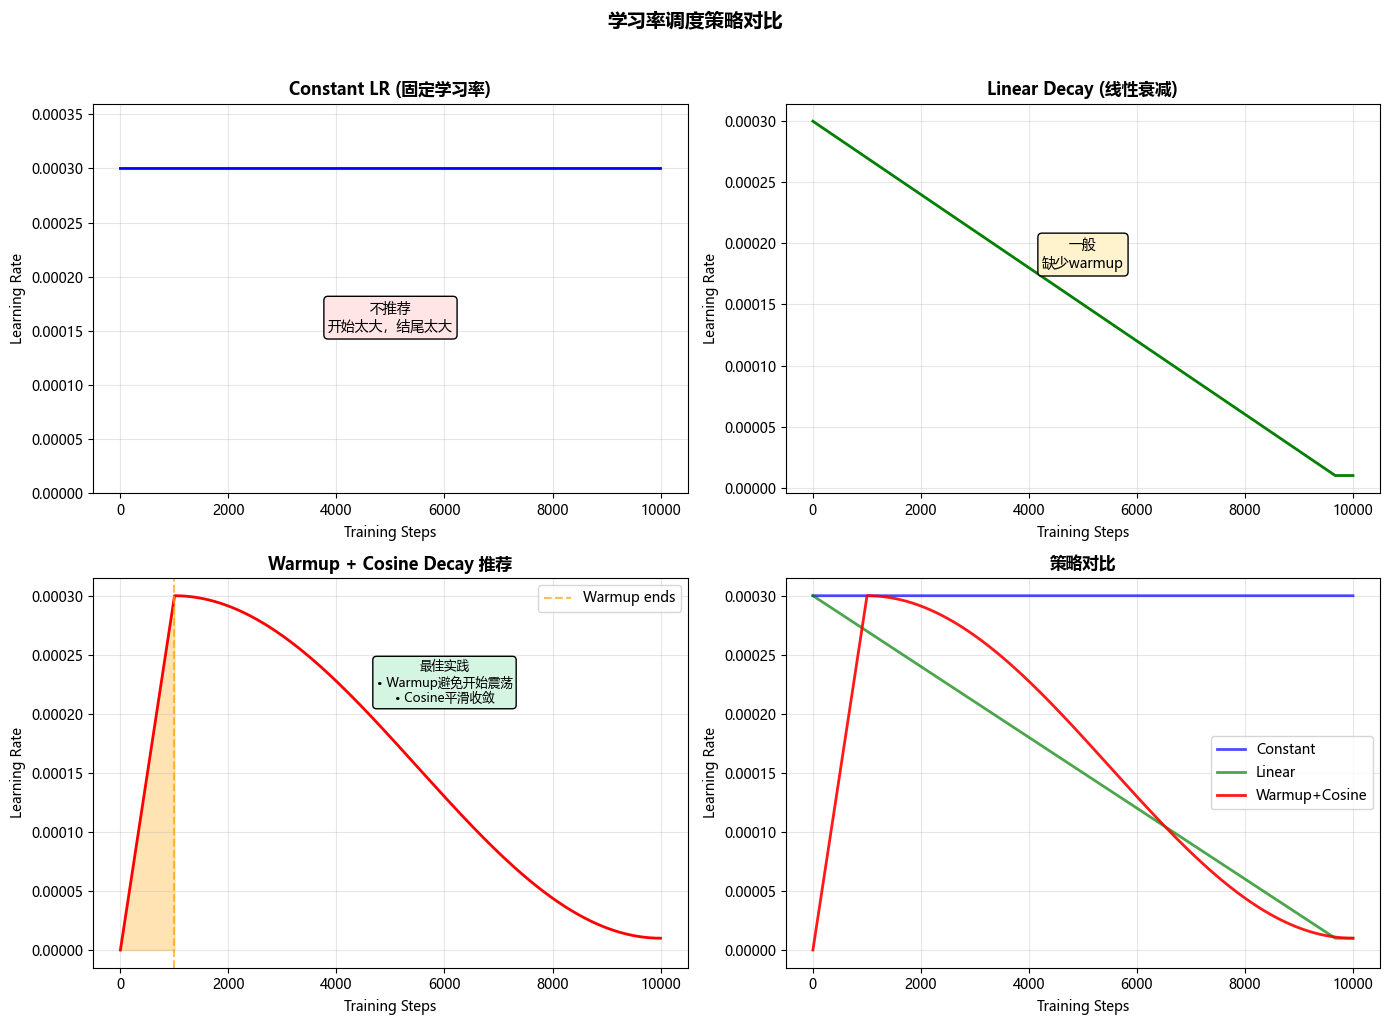


💡 学习率调度要点:
   • Warmup: 开始时学习率从0缓慢增加，避免初期不稳定
   • Cosine Decay: 平滑下降到最小值，帮助模型收敛
   • 典型配置: warmup_ratio=0.1, min_lr=base_lr/10

学习率调度器代码:
scheduler = get_lr_scheduler(optimizer, warmup_steps=1000, total_steps=10000)
# 在每个训练step后调用: scheduler.step()


In [29]:
# 🎨 学习率调度可视化
import matplotlib.pyplot as plt
import numpy as np

def visualize_lr_schedules():
    """
    可视化不同的学习率调度策略
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    total_steps = 10000
    warmup_steps = 1000
    base_lr = 3e-4
    min_lr = 1e-5
    
    steps = np.arange(total_steps)
    
    # 1. Constant (固定学习率)
    ax = axes[0, 0]
    lr_constant = np.ones(total_steps) * base_lr
    ax.plot(steps, lr_constant, 'b-', linewidth=2)
    ax.set_title('Constant LR (固定学习率)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Learning Rate')
    ax.set_ylim(0, base_lr * 1.2)
    ax.grid(True, alpha=0.3)
    ax.text(5000, base_lr * 0.5, '不推荐\n开始太大，结尾太大', fontsize=10, ha='center',
           bbox=dict(boxstyle='round', facecolor='#FFE5E5'))
    
    # 2. Linear Decay (线性衰减)
    ax = axes[0, 1]
    lr_linear = base_lr * (1 - steps / total_steps)
    lr_linear = np.maximum(lr_linear, min_lr)
    ax.plot(steps, lr_linear, 'g-', linewidth=2)
    ax.set_title('Linear Decay (线性衰减)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Learning Rate')
    ax.grid(True, alpha=0.3)
    ax.text(5000, base_lr * 0.6, '一般\n缺少warmup', fontsize=10, ha='center',
           bbox=dict(boxstyle='round', facecolor='#FFF3CD'))
    
    # 3. Warmup + Cosine Decay (✓ 推荐!)
    ax = axes[1, 0]
    lr_warmup_cosine = np.zeros(total_steps)
    # Warmup phase
    lr_warmup_cosine[:warmup_steps] = base_lr * steps[:warmup_steps] / warmup_steps
    # Cosine decay phase
    decay_steps = total_steps - warmup_steps
    for i in range(warmup_steps, total_steps):
        progress = (i - warmup_steps) / decay_steps
        lr_warmup_cosine[i] = min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(np.pi * progress))
    
    ax.plot(steps, lr_warmup_cosine, 'r-', linewidth=2)
    ax.axvline(x=warmup_steps, color='orange', linestyle='--', alpha=0.7, label='Warmup ends')
    ax.fill_between(steps[:warmup_steps], 0, lr_warmup_cosine[:warmup_steps], alpha=0.3, color='orange')
    ax.set_title('Warmup + Cosine Decay 推荐', fontsize=12, fontweight='bold')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Learning Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.text(6000, base_lr * 0.7, '最佳实践\n• Warmup避免开始震荡\n• Cosine平滑收敛', 
           fontsize=9, ha='center', bbox=dict(boxstyle='round', facecolor='#D5F5E3'))
    
    # 4. 对比所有策略
    ax = axes[1, 1]
    ax.plot(steps, lr_constant, 'b-', linewidth=2, label='Constant', alpha=0.7)
    ax.plot(steps, lr_linear, 'g-', linewidth=2, label='Linear', alpha=0.7)
    ax.plot(steps, lr_warmup_cosine, 'r-', linewidth=2, label='Warmup+Cosine', alpha=0.9)
    ax.set_title('策略对比', fontsize=12, fontweight='bold')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Learning Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('学习率调度策略对比', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 学习率调度要点:")
    print("   • Warmup: 开始时学习率从0缓慢增加，避免初期不稳定")
    print("   • Cosine Decay: 平滑下降到最小值，帮助模型收敛")
    print("   • 典型配置: warmup_ratio=0.1, min_lr=base_lr/10")

visualize_lr_schedules()

# 实现学习率调度器
def get_lr_scheduler(optimizer, warmup_steps, total_steps, min_lr_ratio=0.1):
    """
    创建 Warmup + Cosine Decay 学习率调度器
    """
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Warmup phase
            return current_step / warmup_steps
        else:
            # Cosine decay phase
            progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
            return min_lr_ratio + 0.5 * (1 - min_lr_ratio) * (1 + np.cos(np.pi * progress))
    
    from torch.optim.lr_scheduler import LambdaLR
    return LambdaLR(optimizer, lr_lambda)

print("\n学习率调度器代码:")
print("scheduler = get_lr_scheduler(optimizer, warmup_steps=1000, total_steps=10000)")
print("# 在每个训练step后调用: scheduler.step()")

In [30]:
# 训练配置
learning_rate = 3e-4
max_iters = 2000
eval_interval = 200
eval_iters = 50

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss():
    model.eval()
    losses = {'train': 0, 'val': 0}
    
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        total_loss = 0
        count = 0
        for x, y in loader:
            if count >= eval_iters:
                break
            x, y = x.to(device), y.to(device)
            _, loss = model(x, y)
            total_loss += loss.item()
            count += 1
        losses[split] = total_loss / count
    
    model.train()
    return losses

print("开始训练...")
print("=" * 60)

开始训练...


In [31]:
# 训练主循环
train_losses = []
val_losses = []
best_val_loss = float('inf')

start_time = time.time()
iter_count = 0

for epoch in range(max_iters // len(train_loader) + 1):
    for x, y in train_loader:
        if iter_count >= max_iters:
            break
            
        x, y = x.to(device), y.to(device)
        
        # 前向传播
        logits, loss = model(x, y)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 评估
        if iter_count % eval_interval == 0:
            losses = estimate_loss()
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            
            elapsed = time.time() - start_time
            print(f"Iter {iter_count:4d} | Train Loss: {losses['train']:.4f} | Val Loss: {losses['val']:.4f} | Time: {elapsed:.1f}s")
            
            # 保存最佳模型
            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                torch.save(model.state_dict(), BEST_MODEL_PATH)
        
        iter_count += 1

print("=" * 60)
print(f"训练完成! 最佳验证 Loss: {best_val_loss:.4f}")

Iter    0 | Train Loss: 6.3287 | Val Loss: 6.3129 | Time: 0.1s
Iter  200 | Train Loss: 2.7866 | Val Loss: 4.0302 | Time: 1.4s
Iter  400 | Train Loss: 1.1895 | Val Loss: 4.1523 | Time: 2.7s
Iter  600 | Train Loss: 0.3734 | Val Loss: 4.6411 | Time: 4.1s
Iter  800 | Train Loss: 0.1625 | Val Loss: 4.9169 | Time: 5.4s
Iter 1000 | Train Loss: 0.1048 | Val Loss: 5.1995 | Time: 6.7s
Iter 1200 | Train Loss: 0.0822 | Val Loss: 5.3956 | Time: 8.0s
Iter 1400 | Train Loss: 0.0713 | Val Loss: 5.4831 | Time: 9.3s
Iter 1600 | Train Loss: 0.0655 | Val Loss: 5.5655 | Time: 10.5s
Iter 1800 | Train Loss: 0.0640 | Val Loss: 5.6662 | Time: 11.8s
训练完成! 最佳验证 Loss: 4.0302


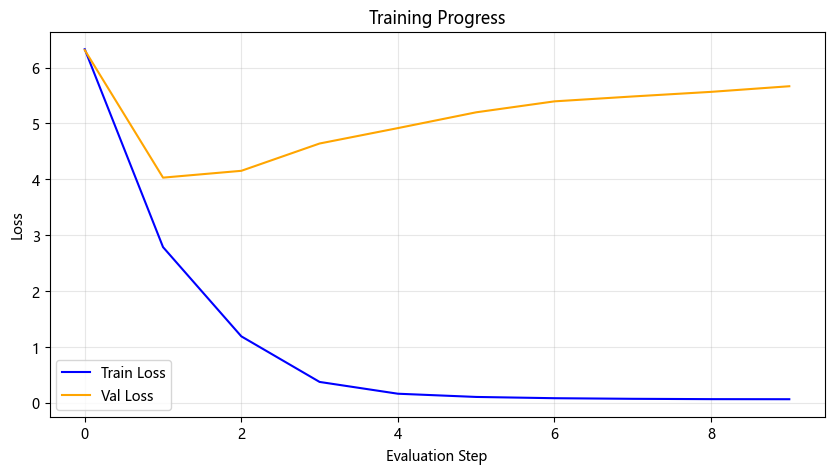

In [14]:
# 可视化训练过程
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.xlabel('Evaluation Step')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## 5. 生成文本！

In [32]:
# 加载最佳模型
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()

# 生成文本
prompt = "企业年度预算通常按部门拆分，\n"
context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)

print(f"Prompt: {prompt}")
print("=" * 60)
print("Generated Text:")
print("=" * 60)

# 生成
generated = model.generate(context, max_new_tokens=200, temperature=0.8, top_k=40)
print(decode(generated[0].tolist()))

Prompt: 企业年度预算通常按部门拆分，

Generated Text:
企业年度预算通常按部门拆分，
业务注务。
业务报警应支持能并发布划需要设置。
机制应明确标。
服务要覆盖级动需要记录分析与定期据一准并定义以支持并统一命名和错误解。
A 或 C0 lres、响计。
网络处理。
指标应原则可据制应通常用标。
报告警应支持一致性与支持一致性。
代码 "vere R uruslurue Y例建议使用 enk",{" R { 1imeeuyum":aosse_oserneoe、d。
ASO任务应支持一


In [33]:
# 尝试不同的 prompt
prompts = [
    "企业年度预算通常按部门拆分，\n",
    "需求评审应记录变更原因，\n",
    "系统容量规划需要考虑\n",
]

for prompt in prompts:
    context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
    generated = model.generate(context, max_new_tokens=100, temperature=0.8, top_k=40)
    
    print(f"\n{'='*60}")
    print(f"Prompt: {prompt}")
    print("-" * 60)
    print(decode(generated[0].tolist()))


Prompt: 企业年度预算通常按部门拆分，

------------------------------------------------------------
企业年度预算通常按部门拆分，
业务要准并定含可复盘发布范则并制。
数据用一致性应支持复件。
数据间与修复需要包含变更记录变更应明确标准并版本发布键制、口。
数据一致性性与关键追踪。
审
数据质量与结论与版本控制。
AMMM单应包含

Prompt: 需求评审应记录变更原因，

------------------------------------------------------------
需求评审应记录变更原因，
文档划版本管理。
模型用户画估。
版本现需求交付与行动更应包含在。
可按器荐OST 或 模型评估。
数据一致评估需要覆盖数据标、rtute" 或 R R 24 :。
数据以避免用星型应可一指标。
数据

Prompt: 系统容量规划需要考虑

------------------------------------------------------------
系统容量规划需要考虑
研发现估。
线与结构: RSMOSOPI Y。
关键接源应记录 或 或 R 或 RPI录并、响应区。
指标与关键用缓存期应准定期进行动标。
数据标。
代码策略与修复滚、响应记录 td us@u_re:


---

## 6. Checkpoint 管理

In [34]:
# 完整的 checkpoint（包含优化器状态）
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'config': config,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to {path}")

def load_checkpoint(path, model, optimizer=None):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Checkpoint loaded from {path}")
    return checkpoint['epoch'], checkpoint['loss']

# 保存完整 checkpoint
save_checkpoint(model, optimizer, iter_count, best_val_loss, CHECKPOINT_PATH)

Checkpoint saved to checkpoint.pt


---

## 本章总结

1. **数据工程**
   - Dataset 封装数据逻辑
   - DataLoader 处理批量加载和 shuffle

2. **训练循环**
   - Forward → Loss → Backward → Step
   - 定期评估验证集
   - 保存最佳模型

3. **Checkpoint**
   - 保存模型权重
   - 保存优化器状态（可继续训练）


---

## 思考

1. **增加模型规模**：尝试 6 层、256 维
2. **学习率调度**：添加 warmup 和 cosine decay
3. **混合精度训练**：使用 AMP 加速训练

In [ ]:
# 练习空间

